In [161]:
import pandas as pd
from datetime import datetime

In [162]:
# load data

dataset = pd.read_csv('930-data-export.csv')
dataset.set_index(pd.to_datetime(dataset[['year', 'month', 'day', 'hour']]), inplace = True)
dataset.drop(['year', 'month', 'day', 'hour'], axis=1, inplace = True)
print(dataset)
# manually specify column names
dataset.columns = ['BANC Demand (MWh)','CISO Demand (MWh)','IID Demand (MWh)','LDWP Demand (MWh)','TIDC Demand (MWh)','Total CAL Demand (MWh)']
dataset.index.name = 'date'
# mark all NA values with 0
dataset.fillna(0, inplace=True)
# drop the first 24 hours
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pwrgrid.csv')

                     BANC Demand (MWh)  CISO Demand (MWh)  IID Demand (MWh)  \
2024-04-20 12:00:00             1988.0            24818.0             483.0   
2024-04-20 01:00:00             1873.0            24573.0             437.0   
2024-04-20 02:00:00             1736.0            23950.0             393.0   
2024-04-20 03:00:00             1605.0            22971.0             353.0   
2024-04-20 04:00:00             1512.0            21588.0             318.0   
...                                ...                ...               ...   
2024-05-20 04:00:00             1605.0            22450.0             353.0   
2024-05-20 05:00:00             1520.0            21600.0             324.0   
2024-05-20 06:00:00             1471.0            20804.0             302.0   
2024-05-20 07:00:00             1462.0            20454.0             291.0   
2024-05-20 08:00:00             1490.0            20215.0             285.0   

                     LDWP Demand (MWh)  TIDC Demand

In [163]:
from pandas import read_csv
from matplotlib import pyplot

#load power grid dataset
dataset = read_csv('pwrgrid.csv', header = 0, index_col = 0)
values = dataset.values

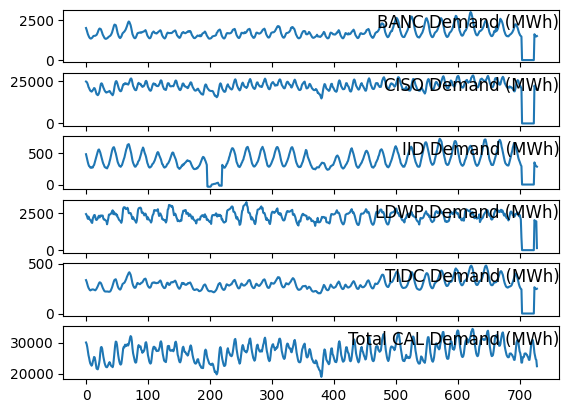

In [164]:

#We will be plotting all of the columns that we have including the Total CAL Demand which is the total demand for California 
pyplot.figure()
for col in range(1, len(dataset.columns)+1):
    pyplot.subplot(len(dataset.columns), 1, col)
    pyplot.plot(values[:, col-1])
    pyplot.title(dataset.columns[col-1], y = 0.5, loc = 'right')
pyplot.show()

LSTM FORECAST PREP IS BELOW (MACHINE LEARNING MASTERY GUIDE)

In [165]:
from pandas import read_csv
from matplotlib import pyplot
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

#load power grid dataset
dataset = read_csv('pwrgrid.csv', header = 0, index_col = 0)
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [166]:
nvars = dataset.shape[1]
df = pd.DataFrame(scaled)
# frame as supervised learning

cols, names = list(), list()
 # input sequence (t-n, ... t-1)
for i in range(3, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(nvars)]
 # forecast sequence (t, t+1, ... t+n)
for i in range(0, 1):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(nvars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(nvars)]
 # put it all together
agg = concat(cols, axis=1)
agg.columns = names
 # drop rows with NaN values
agg.dropna(inplace=True)
reframed = agg



print(reframed.head())

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.667786   0.872859   0.678431   0.751395   0.622449   0.716377   
4   0.629157   0.864242   0.618301   0.728766   0.540816   0.684448   
5   0.583137   0.842331   0.560784   0.690639   0.428571   0.623234   
6   0.539133   0.807899   0.508497   0.652821   0.316327   0.539766   
7   0.507894   0.759259   0.462745   0.699628   0.229592   0.450945   

   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  ...  var3(t-1)  var4(t-1)  \
3   0.629157   0.864242   0.618301   0.728766  ...   0.560784   0.690639   
4   0.583137   0.842331   0.560784   0.690639  ...   0.508497   0.652821   
5   0.539133   0.807899   0.508497   0.652821  ...   0.462745   0.699628   
6   0.507894   0.759259   0.462745   0.699628  ...   0.430065   0.663360   
7   0.480349   0.736292   0.430065   0.663360  ...   0.420915   0.639182   

   var5(t-1)  var6(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
3   0.428571   0.623234  0.539133  0.80

In [167]:
# split into train and test sets
values = reframed.values
n_train_hours = 10 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :24], train[:, -6]
test_X, test_y = test[:, :24], test[:, -6]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 4, 6))
test_X = test_X.reshape((test_X.shape[0], 4, 6))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(240, 4, 6) (240,) (486, 4, 6) (486,)


Epoch 1/100


C:\Users\FCYLEC6\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 - 1s - 277ms/step - loss: 0.4820 - val_loss: 0.1985
Epoch 2/100
4/4 - 0s - 16ms/step - loss: 0.1106 - val_loss: 0.2060
Epoch 3/100
4/4 - 0s - 15ms/step - loss: 0.1697 - val_loss: 0.1022
Epoch 4/100
4/4 - 0s - 15ms/step - loss: 0.0686 - val_loss: 0.0964
Epoch 5/100
4/4 - 0s - 15ms/step - loss: 0.0917 - val_loss: 0.0735
Epoch 6/100
4/4 - 0s - 15ms/step - loss: 0.0505 - val_loss: 0.0617
Epoch 7/100
4/4 - 0s - 14ms/step - loss: 0.0549 - val_loss: 0.0574
Epoch 8/100
4/4 - 0s - 14ms/step - loss: 0.0439 - val_loss: 0.0573
Epoch 9/100
4/4 - 0s - 14ms/step - loss: 0.0435 - val_loss: 0.0526
Epoch 10/100
4/4 - 0s - 14ms/step - loss: 0.0393 - val_loss: 0.0514
Epoch 11/100
4/4 - 0s - 14ms/step - loss: 0.0379 - val_loss: 0.0507
Epoch 12/100
4/4 - 0s - 14ms/step - loss: 0.0343 - val_loss: 0.0520
Epoch 13/100
4/4 - 0s - 14ms/step - loss: 0.0325 - val_loss: 0.0482
Epoch 14/100
4/4 - 0s - 14ms/step - loss: 0.0308 - val_loss: 0.0485
Epoch 15/100
4/4 - 0s - 16ms/step - loss: 0.0290 - val_loss: 0.0492


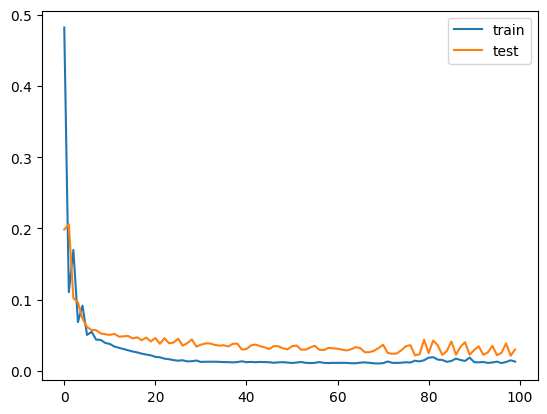

In [168]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error
import tensorflow.keras as keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(175, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [169]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 24))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Test RMSE: 147.044
